combining code from Properties.ipynb and ObservedTrend.ipynb to make plots of trends over distance and time for the paper

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.interpolate import UnivariateSpline
from pyproj import Geod

import warnings
warnings.filterwarnings("ignore")

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [3]:
obs = pd.read_csv(IOPATH)

In [4]:
# reduce potential bias caused by sampling programs going out in different months
# summer only (april-sep inclusive) based on PreliminaryCurrentAnalysis.ipynb
obs = obs[(obs.month>=4)&(obs.month<=9)]
obs

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
1,1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
2,2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
3,3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
4,4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721761,1721761,1721761,1804439,2024-09-30 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.000050,33.328536,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,133.256480,-0.0
1721762,1721762,1721762,1804440,2024-09-30 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.388119,32.661681,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,133.256480,-0.0
1721763,1721763,1721763,1804441,2024-09-30 00:00:00+00:00,-124.31,44.64,0.0,0.000000,9.441516,33.522238,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,377.942065,NaN
1721764,1721764,1721764,1804442,2024-09-30 00:00:00+00:00,-124.27,47.13,0.0,0.000000,11.669242,32.555657,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,133.256480,-0.0


In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
def cc_dist(NS, EW): # making it a function here bc we need to do this calc over and over again for the lit review results
    abs_a = NS.abs()
    abs_b = EW.abs()

    dist = np.select(
        [
            abs_a < abs_b,       # a closer to zero
            abs_b < abs_a,       # b closer to zero
            abs_a.isna(),        # a NaN, take b
            abs_b.isna()         # b NaN, take a
        ],
        [
            NS,
            EW,
            EW,
            NS
        ],
        default=np.nan
    )

    # and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
    dist[NS<0] = EW[NS<0]
    return dist

obs_cc['dist']=cc_dist(obs_cc.NSdist, obs_cc.EWdist)


In [6]:
np.max(obs_shelf.dist)

2953.450573134264

In [7]:
np.min(obs_cc.dist)

-1400.5707163109528

# Functions

In [8]:
def plot_property_NStrend(d_out, var_string, current_string, subplot_pos):
    if current_string == 'CUC':
        obs_used = obs_cuc
    elif current_string == 'shelf':
        obs_used = obs_shelf
    elif current_string == 'CC':
        obs_used = obs_cc
    else:
        raise ValueError("Invalid current_string. Use 'CC', 'CUC', or 'shelf'.")

    ylim_dict = {'spice': [-2, 3], 'temperature (degC)': [5, 20], 'salinity (g kg-1)': [31, 35],
                 'DO (umol kg-1)': [0,400], 'NO3 (uM)': [0,40], '[TA-DIC] (uM)': [-50,300]}

    x = np.asarray(d_out)
    y = np.asarray(obs_used[var_string])
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 5:
        raise ValueError("Not enough finite data to fit a trend.")

    # --- bin distances (vectorized) ---
    base = 150.0
    x_bin = np.round(x[m] / base) * base

    df = pd.DataFrame({'x_bin': x_bin, 'y': y[m]})
    g = df.groupby('x_bin', sort=True)

    xu   = g['y'].mean().index.values
    ybar = g['y'].mean().values
    s    = g['y'].std(ddof=1).values
    n    = g.size().values

    # --- drop small-n bins ---
    keep = n >= 3
    xu, ybar, s, n = xu[keep], ybar[keep], s[keep], n[keep]
    if xu.size < 5:
        raise ValueError("Too few bins with n≥3 to fit a smooth trend.")

    # --- standard error and t-crit ---
    se = s / np.sqrt(n)
    dfree = np.maximum(n - 1, 1)  # avoid 0
    tcrit = stats.t.ppf(0.975, df=dfree)

    # --- smoothing: weighted spline on mean; separate smooth on log(se) ---
    # weights = 1/se (clip to avoid infinities)
    se_clip = np.clip(se, np.nanmax(se)*1e-6, np.nanmax(se)*1e6)
    w = 1.0 / se_clip

    # --- cap leverage of dominant bins so we don't get crazy jumps just bc there's a lot of data
    max_ratio = 10.0  # max allowed ratio of (weight / median weight)
    med_w = np.median(w)
    w = np.minimum(w, med_w * max_ratio)
    w /= med_w  # normalize so median weight ~ 1
    # ===========================================

    # Choose s proportional to variance * number of points (rule of thumb)
    s_mean = np.nanvar(ybar) * xu.size

    mean_spline = UnivariateSpline(xu, ybar, w=w, s=s_mean)

    # Smooth log(SE) to keep positivity and avoid negative wiggles
    se_pos = np.clip(se, np.finfo(float).eps, None)
    logse_spline = UnivariateSpline(xu, np.log(se_pos), s=xu.size * 0.5)

    # Evaluate on a fine grid
    x_fine = np.linspace(xu.min(), xu.max(), 600)
    y_smooth = mean_spline(x_fine)
    se_smooth = np.exp(logse_spline(x_fine))

    # tcrit varies slowly with n; use median df for evaluation (or spline tcrit too)
    tcrit_med = stats.t.ppf(0.975, df=int(np.median(dfree)))
    lower = y_smooth - tcrit_med * se_smooth
    upper = y_smooth + tcrit_med * se_smooth

    # --- plot ---
    ax[subplot_pos].scatter(x[m], y[m], s=2, alpha=0.1, c='lightgray', linewidths=0)
    ax[subplot_pos].plot(x_fine, y_smooth, lw=2, label='Mean', color='#364B9A')
    ax[subplot_pos].fill_between(x_fine, lower, upper, color='#98CAE1', label='95% CI')

    if var_string in ylim_dict:
        ax[subplot_pos].set_ylim(ylim_dict[var_string])

    ax[subplot_pos].set_xlim(-1415, 2950)
    ax[subplot_pos].set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    ax[subplot_pos].set_xticklabels([])
    secax = ax[subplot_pos].secondary_xaxis('top')
    secax.set_xlim(-1415, 2950)
    secax.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    if current_string == 'CC':
        secax.set_xticklabels(['','-133.3$^\circ$ E','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)
    else:
        secax.set_xticklabels(['','51.0$^\circ$ N','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)
    
    # ax[subplot_pos].plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax[subplot_pos].plot([805,805],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax[subplot_pos].plot([1654,1654],[-1000,1000],'k--',alpha=0.5) # Point Conception

    # return xu, ybar


In [10]:
##################
# Trends in time #
##################

def plot_ratediff_NS_CI(var_string, current_string, subplot_pos, yrlabel=False,
                        n_bins=9, cov_type="HAC", hac_maxlags=1,
                        annual_stat="median", min_obs_per_year=3,
                        min_years=4, min_span_years=10):
    # pick data by current
    if current_string == 'CUC':
        obs_used = obs_cuc
    elif current_string == 'shelf':
        obs_used = obs_shelf
    elif current_string == 'CC':
        obs_used = obs_cc
    else:
        raise ValueError("Invalid current_string. Use 'CC', 'CUC', or 'shelf'.")

    ylim_dict = {'spice':[-0.04,0.02], 'temperature (degC)': [-0.2,0.2],
                 'salinity (g kg-1)':[-0.03,0.03], 'DO (umol kg-1)':[-3.7,3],
                 'NO3 (uM)':[-1.9,0.5], '[TA-DIC] (uM)':[-10,17]}

    # bin edges/centers/widths
    dist = np.asarray(obs_used['dist'])
    dmin, dmax = -1415, 2950
    edges   = np.linspace(dmin, dmax, n_bins+1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    # keep your "narrow bar" choice but ensure width is positive
    widths  = np.maximum((edges[1:] - edges[:-1]) - 200, 1e-6)

    slopes      = np.full(n_bins, np.nan)
    lo95        = np.full(n_bins, np.nan)
    hi95        = np.full(n_bins, np.nan)
    year_span   = np.full(n_bins, np.nan)   # NaN => excluded
    n_years_arr = np.full(n_bins, np.nan)

    years_all = np.asarray(obs_used['year'])
    y_all     = np.asarray(obs_used[var_string])

    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        msk = (dist >= lo) & (dist < hi) & np.isfinite(years_all) & np.isfinite(y_all)
        if not np.any(msk):
            continue

        # (1) aggregate to annual values with ≥ min_obs_per_year
        df_bin = pd.DataFrame({
            "year": years_all[msk].astype(float),
            "val":  y_all[msk].astype(float)
        })

        # distinct years and span
        n_years = len(set(df_bin["year"]))
        span = float(df_bin["year"].max() - df_bin["year"].min() + 1)

        if (n_years < min_years) or (span < min_span_years):
            # exclude this bin from both points and bars
            continue

        grp = df_bin.groupby("year", as_index=False).agg(
            n=("val", "size"),
            med=("val", "median"),
            mean=("val", "mean")
        )
        grp = grp[grp["n"] >= min_obs_per_year]
        if grp.empty:
            continue

        n_years_arr[i] = n_years
        year_span[i]   = span

        Y_ann = grp["med"].values if annual_stat == "median" else grp["mean"].values
        X_ann = grp["year"].values

        # (2) OLS with equal weight per year + (3) robust SEs
        X = sm.add_constant(X_ann)
        ols = sm.OLS(Y_ann, X)
        if cov_type == "HAC":
            res = ols.fit(cov_type="HAC", cov_kwds={"maxlags": int(hac_maxlags)})
        else:
            res = ols.fit(cov_type=cov_type)

        slopes[i] = res.params[1]
        ci = res.conf_int(alpha=0.05)
        if ci.shape[0] > 1:
            lo95[i], hi95[i] = ci[1, 0], ci[1, 1]

    # === plotting ===
    ax_tr = ax[subplot_pos]
    ax_yr = ax_tr.twinx()

    # Only plot bars for bins that passed filters
    m_bar = np.isfinite(year_span)
    if np.any(m_bar):
        ax_yr.bar(centers[m_bar], year_span[m_bar], width=widths[m_bar],
                  color='#98CAE1', alpha=0.7, zorder=1)
    ax_yr.set_ylim([0,100])
    ax_yr.set_yticks([10,20,30,40,50,60,70,80,90,100])
    ax_yr.grid(axis='y',color='w',zorder=2)
    if yrlabel==True:
        ax_yr.set_ylabel('Year-span (yr)',fontsize=10)
        ax_yr.set_yticklabels(['','20','','40','','60','','80','','100'],fontsize=8)
    else:
        ax_yr.set_yticklabels([])


    # points + 95% CI for valid bins only
    # first plot the points with more than 20 year spans in data
    m_ok = np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) & np.isfinite(year_span) & (year_span>=20)
    if np.any(m_ok):
        yerr = np.vstack([hi95[m_ok] - slopes[m_ok], slopes[m_ok] - lo95[m_ok]])
        ax_tr.errorbar(centers[m_ok], slopes[m_ok], yerr=yerr, fmt='.', ms=7,
                       c='#364B9A', label='95% CI',zorder=4)
    # first plot the points with less than 20 years in a lighter color
    m_ok = np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) & np.isfinite(year_span) & (year_span<20)
    if np.any(m_ok):
        yerr = np.vstack([hi95[m_ok] - slopes[m_ok], slopes[m_ok] - lo95[m_ok]])
        ax_tr.errorbar(centers[m_ok], slopes[m_ok], yerr=yerr, fmt='.', ms=7,
                       c='#364B9A', alpha=0.35, label='95% CI',zorder=4)

    ax_tr.set_xlim(-1420, 2900)
    ax_tr.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    ax_tr.set_xticklabels(['','-500','','500','','1500','','2500'],rotation=90)
    ax_tr.axhline(0, color='black', lw=1,zorder=3)

    if var_string in ylim_dict:
        ax_tr.set_ylim(ylim_dict[var_string])

    # add lines for JdF, Cape Mendocino, and Point Conception
    # ax_tr.plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax_tr.plot([805,805],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax_tr.plot([1654,1654],[-1000,1000],'k--',alpha=0.5) # Point Conception
    # ax_tr.text(0.34,0.02,'SS',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)
    ax_tr.text(0.65,0.02,'CM',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)
    ax_tr.text(0.82,0.02,'PC',ha='right',va='bottom',transform=ax_tr.transAxes,fontsize=10)

    ax_yr.set_zorder(1)
    ax_tr.set_zorder(3)
    ax_tr.patch.set_alpha(0)

In [11]:
geod = Geod(ellps='WGS84')
dist = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/distances.csv')
lons_NS, lats_NS, d_NS = dist.lonNS, dist.latNS, dist.distNS
lons_EW, lats_EW, d_EW = dist.lonEW, dist.latEW, dist.distEW

def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
        
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km * 1000:
            d_NS_out[i] = d_NS[idx_NS]
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW]
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out

# Temperature

In [12]:
# load in lit review results here
points = 10
d = {'lon1':np.zeros(points),'lon2':np.zeros(points),'lat1':np.zeros(points),'lat2':np.zeros(points),
     'rate':np.zeros(points),'sdev':np.zeros(points),'current':np.zeros(points),'dist':np.zeros(points),'distDiff':np.zeros(points)}
Tlit = pd.DataFrame(d)

Tlit['lon1'] = [-144.9, -121, -119.7, -122.82, -122.88, -120.97, -119.06, -126, -116, -129.5] # two lats and lons to deal with location ranges, same if no range
Tlit['lon2'] = [-144.9, -121, -119.7, -122.82, -122.88, -120.97, -119.06, -126, -116, -129.5]
Tlit['lat1'] = [50.1, 30, 34.3, 37.75, 37.36, 34.71, 33.74, 40, 27, 51]
Tlit['lat2'] = [50.1, 34, 34.3, 37.75, 37.36, 34.71, 33.74, 45, 32, 51]

Tlit['current'] = ['CC', 'CC', 'shelf', 'shelf', 'shelf', 'shelf', 'shelf', 'CC', 'CC', 'shelf']
Tlit['rate'] = [0, 0.0352, 0.01, -0.032, -0.034, -0.043, -0.003, 0.06, 0.06, 0.013]
Tlit['sdev'] = [0,0,0,0,0,0,0, 0.05,0.05,0.012]

# calculate distances
distance_NS1,distance_EW1=along_track_distance_array(Tlit.lon1,Tlit.lat1)
distance_NS2,distance_EW2=along_track_distance_array(Tlit.lon2,Tlit.lat2)

Tlit['dist'][(Tlit.current == 'CUC') | (Tlit.current == 'shelf')] = np.nanmean([distance_NS1,distance_NS2],axis=0)
Tlit['distDiff'][(Tlit.current == 'CUC') | (Tlit.current == 'shelf')] = np.abs(distance_NS1-distance_NS2)/2

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = np.abs(np.nanmean([distance_NS1,distance_NS2],axis=0)[(Tlit.current == 'CC')])
abs_b = np.abs(np.nanmean([distance_EW1,distance_EW2],axis=0)[(Tlit.current == 'CC')])

Tlit['dist'][(Tlit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        np.nanmean([distance_NS1,distance_NS2],axis=0)[(Tlit.current == 'CC')],
        np.nanmean([distance_EW1,distance_EW2],axis=0)[(Tlit.current == 'CC')],
        np.nanmean([distance_EW1,distance_EW2],axis=0)[(Tlit.current == 'CC')],
        np.nanmean([distance_NS1,distance_NS2],axis=0)[(Tlit.current == 'CC')]
    ],
    default=np.nan
)
Tlit['distDiff'][(Tlit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        np.abs(distance_NS1-distance_NS2)[(Tlit.current == 'CC')]/2,
        np.abs(distance_EW1-distance_EW2)[(Tlit.current == 'CC')]/2,
        np.abs(distance_EW1-distance_EW2)[(Tlit.current == 'CC')]/2,
        np.abs(distance_NS1-distance_NS2)[(Tlit.current == 'CC')]/2
    ],
    default=np.nan
)

Tlit

,lon1,lon2,lat1,lat2,rate,sdev,current,dist,distDiff
0,-144.90,-144.90,50.10,50.10,0.0000,0.000,CC,-1375.012049,0.000000
1,-121.00,-121.00,30.00,34.00,0.0352,0.000,CC,1814.101197,160.093380
2,-119.70,-119.70,34.30,34.30,0.0100,0.000,shelf,1724.431472,0.000000
3,-122.82,-122.82,37.75,37.75,-0.0320,0.000,shelf,1233.713039,0.000000
4,-122.88,-122.88,37.36,37.36,-0.0340,0.000,shelf,1303.489996,0.000000
5,-120.97,-120.97,34.71,34.71,-0.0430,0.000,shelf,1654.007817,0.000000
6,-119.06,-119.06,33.74,33.74,-0.0030,0.000,shelf,1794.959489,0.000000
7,-126.00,-126.00,40.00,45.00,0.0600,0.050,CC,601.694885,284.811600
8,-116.00,-116.00,27.00,32.00,0.0600,0.050,CC,2444.420895,213.054132
9,-129.50,-129.50,51.00,51.00,0.0130,0.012,shelf,-410.525610,0.000000


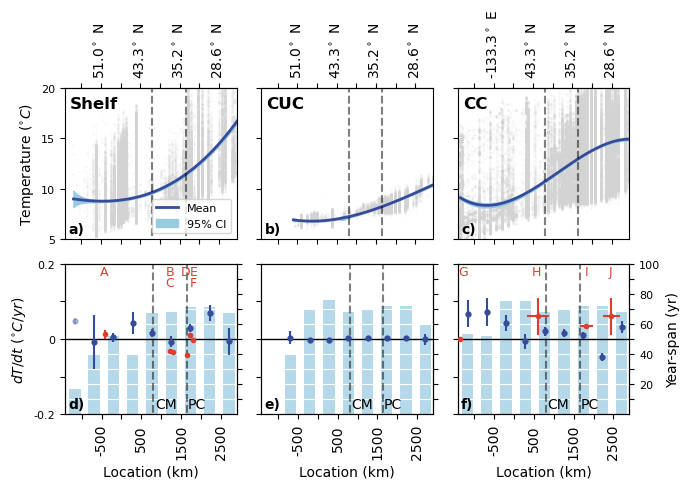

In [13]:
variable = 'temperature (degC)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([5,10,15,20])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels(['5','10','15','20'],fontsize=8)
ax[0,0].set_ylabel('Temperature ($^{\circ} C$)',fontsize=10)
ax[0,0].legend(loc='lower right', fontsize=8)

# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.2,-0.1,0,0.1,0.2])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$dT/dt \,\,(^{\circ} C/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-0.2','','0','','0.2'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

# add observational data
ax[1,0].errorbar(Tlit.dist[Tlit.current=='shelf'], Tlit.rate[Tlit.current=='shelf'],yerr=Tlit.sdev[Tlit.current=='shelf'],xerr=Tlit.distDiff[Tlit.current=='shelf'], c='#DD3D2D',fmt='.',zorder=4)
ax[1,2].errorbar(Tlit.dist[Tlit.current=='CC'], Tlit.rate[Tlit.current=='CC'],yerr=Tlit.sdev[Tlit.current=='CC'],xerr=Tlit.distDiff[Tlit.current=='CC'], c='#DD3D2D',fmt='.',zorder=4)

# add text to the observational data
ax[1,0].text(0.23,0.99,'A',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)
ax[1,0].text(0.61,0.99,'B',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)
ax[1,0].text(0.61,0.92,'C',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)
ax[1,0].text(0.70,0.99,'D',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)
ax[1,0].text(0.75,0.99,'E',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)
ax[1,0].text(0.75,0.92,'F',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9,zorder=6)

ax[1,2].text(0.03,0.99,'G',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9,zorder=6)
ax[1,2].text(0.46,0.99,'H',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9,zorder=6)
ax[1,2].text(0.75,0.99,'I',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9,zorder=6)
ax[1,2].text(0.89,0.99,'J',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9,zorder=6)


plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/TempTrends.png')

# Salinity

In [14]:
# load in lit review results here
points = 3
d = {'lon':np.zeros(points),'lat':np.zeros(points),'rate':np.zeros(points),'sdev':np.zeros(points),'current':np.zeros(points),'dist':np.zeros(points)}
Slit = pd.DataFrame(d)

Slit['lon'] = [-144.9, -144.9, -126.7]
Slit['lat'] = [50.1, 50.1, 48.65]
Slit['current'] = ['CC', 'CC', 'CC']
Slit['rate'] = [-0.0027, -0.003, 0.014]
Slit['sdev'] = [0.0015, 0.002, 0.01]

# calculate distances
distance_NS,distance_EW=along_track_distance_array(Slit.lon,Slit.lat)
Slit['dist'][(Slit.current == 'CUC') | (Slit.current == 'shelf')] = distance_NS

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = np.abs(distance_NS[(Slit.current == 'CC')])
abs_b = np.abs(distance_EW[(Slit.current == 'CC')])

Slit['dist'][(Slit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        distance_NS[(Slit.current == 'CC')],
        distance_EW[(Slit.current == 'CC')],
        distance_EW[(Slit.current == 'CC')],
        distance_NS[(Slit.current == 'CC')]
    ],
    default=np.nan
)

Slit

,lon,lat,rate,sdev,current,dist
0,-144.9,50.10,-0.0027,0.0015,CC,-1375.012049
1,-144.9,50.10,-0.0030,0.0020,CC,-1375.012049
2,-126.7,48.65,0.0140,0.0100,CC,-0.000000


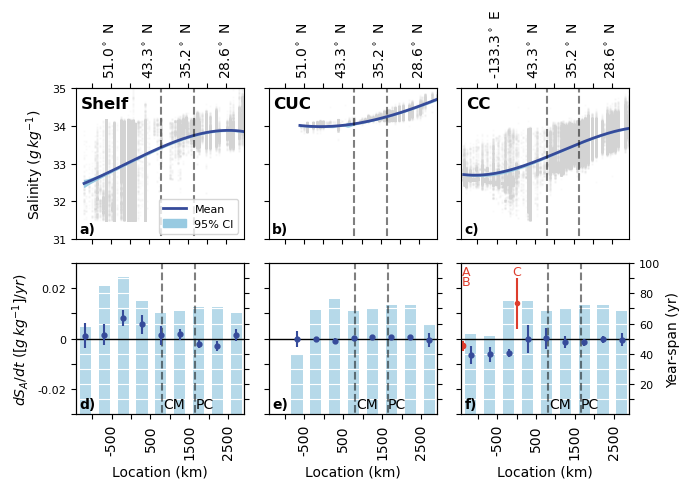

In [15]:
variable = 'salinity (g kg-1)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([31,32,33,34,35])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([31,32,33,34,35],fontsize=8)
ax[0,0].set_ylabel('Salinity ($g\,kg^{-1}$)',fontsize=10)
ax[0,0].legend(fontsize=8)



# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$dS_A/dt \,\,([g\,kg^{-1}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['','-0.02','','0','','0.02',''],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

# add observational data
ax[1,0].errorbar(Slit.dist[Slit.current=='shelf'], Slit.rate[Slit.current=='shelf'],yerr=Slit.sdev[Slit.current=='shelf'], c='#DD3D2D',fmt='.')
ax[1,2].errorbar(Slit.dist[Slit.current=='CC'], Slit.rate[Slit.current=='CC'],yerr=Slit.sdev[Slit.current=='CC'], c='#DD3D2D',fmt='.')

ax[1,2].text(0.03,0.99,'A',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9)
ax[1,2].text(0.03,0.92,'B',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9)
ax[1,2].text(0.33,0.99,'C',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9)

plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/SalTrends.png')

# Spice

In [16]:
# load in lit review results here
points = 3
d = {'lon':np.zeros(points),'lat':np.zeros(points),'rate':np.zeros(points),'sdev':np.zeros(points),'current':np.zeros(points),'dist':np.zeros(points)}
SPlit = pd.DataFrame(d)

SPlit['lon'] = [-118, -123, -120]
SPlit['lat'] = [30,35,34]
SPlit['current'] = ['CUC', 'CUC','CUC']
SPlit['rate'] = [0.0035,0.0035,0.0014]
SPlit['sdev'] = np.nan

# calculate distances
distance_NS,distance_EW=along_track_distance_array(SPlit.lon,SPlit.lat)
SPlit['dist'][(SPlit.current == 'CUC') | (SPlit.current == 'shelf')] = distance_NS

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = np.abs(distance_NS[(SPlit.current == 'CC')])
abs_b = np.abs(distance_EW[(SPlit.current == 'CC')])

SPlit['dist'][(SPlit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        distance_NS[(SPlit.current == 'CC')],
        distance_EW[(SPlit.current == 'CC')],
        distance_EW[(SPlit.current == 'CC')],
        distance_NS[(SPlit.current == 'CC')]
    ],
    default=np.nan
)

SPlit

,lon,lat,rate,sdev,current,dist
0,-118,30,0.0035,NaN,CUC,2365.639105
1,-123,35,0.0035,NaN,CUC,1513.477699
2,-120,34,0.0014,NaN,CUC,1724.431472


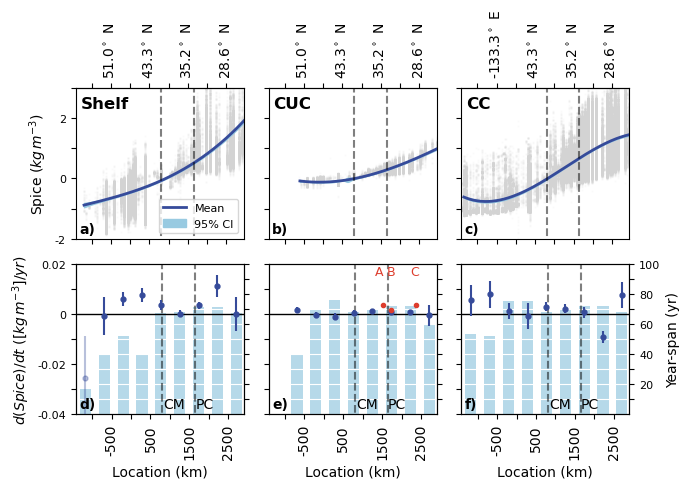

In [17]:
variable = 'spice'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([-2,-1,0,1,2,3])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels(['-2','','0','','2',''],fontsize=8)
ax[0,0].set_ylabel('Spice ($kg \, m^{-3}$)',fontsize=10)
ax[0,0].legend(loc='lower right', fontsize=8)

# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-0.04,-0.03,-0.02,-0.01,0,0.01,0.02])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(Spice)/dt \,\,([kg\,m^{-3}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-0.04','','-0.02','','0','','0.02'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

# add observational data
ax[1,1].errorbar(SPlit.dist[SPlit.current=='CUC'], SPlit.rate[SPlit.current=='CUC'],yerr=SPlit.sdev[SPlit.current=='CUC'], c='#DD3D2D',fmt='.',zorder=6)

ax[1,1].text(0.66,0.99,'A',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.73,0.99,'B',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.87,0.99,'C',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)

plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/SpiceTrends.png')

# DO

In [18]:
# load in lit review results here
points = 10
d = {'lon1':np.zeros(points),'lon2':np.zeros(points),'lat1':np.zeros(points),'lat2':np.zeros(points),
     'rate':np.zeros(points),'sdev':np.zeros(points),'current':np.zeros(points),'dist':np.zeros(points),'distDiff':np.zeros(points)}
Oxlit = pd.DataFrame(d)

Oxlit['lon1'] = [-120, -122.5, -125.09, -125.09, -126, -126, -126, -144.9, -129.5, -129.5]
Oxlit['lon2'] = [-120, -122.5, -125.09, -125.09, -126, -126, -126, -144.9, -129.5, -129.5]
Oxlit['lat1'] = [30, 29, 37.93, 37.93, 44.66, 44.66, 44.66, 50.1, 51, 51]
Oxlit['lat2'] = [35, 33.4, 37.93, 37.93, 44.66, 44.66, 44.66, 50.1, 51, 51]
Oxlit['current'] = ['CUC','CUC','CUC','CUC','CUC','shelf','CC','CC','shelf','CUC']
Oxlit['rate'] = [-0.8,-1.285,-1.785,-2.725,-0.745,-0.7,-0.31,-0.5,-1.07,-1.11]
Oxlit['sdev'] = [0,0.415,1.115,0.185,0.2,0.2,0.03,0.25,0.62,0.6]


# calculate distances
distance_NS1,distance_EW1=along_track_distance_array(Oxlit.lon1,Oxlit.lat1)
distance_NS2,distance_EW2=along_track_distance_array(Oxlit.lon2,Oxlit.lat2)

Oxlit['dist'][(Oxlit.current == 'CUC') | (Oxlit.current == 'shelf')] = np.nanmean([distance_NS1,distance_NS2],axis=0)
Oxlit['distDiff'][(Oxlit.current == 'CUC') | (Oxlit.current == 'shelf')] = np.abs(distance_NS1-distance_NS2)/2

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = np.abs(np.nanmean([distance_NS1,distance_NS2],axis=0)[(Oxlit.current == 'CC')])
abs_b = np.abs(np.nanmean([distance_EW1,distance_EW2],axis=0)[(Oxlit.current == 'CC')])

Oxlit['dist'][(Oxlit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        np.nanmean([distance_NS1,distance_NS2],axis=0)[(Oxlit.current == 'CC')],
        np.nanmean([distance_EW1,distance_EW2],axis=0)[(Oxlit.current == 'CC')],
        np.nanmean([distance_EW1,distance_EW2],axis=0)[(Oxlit.current == 'CC')],
        np.nanmean([distance_NS1,distance_NS2],axis=0)[(Oxlit.current == 'CC')]
    ],
    default=np.nan
)
Oxlit['distDiff'][(Oxlit.current == 'CC')] = np.select(
    [
        abs_a <= abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        np.isnan(abs_a),        # a NaN, take b
        np.isnan(abs_b)         # b NaN, take a
    ],
    [
        np.abs(distance_NS1-distance_NS2)[(Oxlit.current == 'CC')]/2,
        np.abs(distance_EW1-distance_EW2)[(Oxlit.current == 'CC')]/2,
        np.abs(distance_EW1-distance_EW2)[(Oxlit.current == 'CC')]/2,
        np.abs(distance_NS1-distance_NS2)[(Oxlit.current == 'CC')]/2
    ],
    default=np.nan
)

Oxlit

,lon1,lon2,lat1,lat2,rate,sdev,current,dist,distDiff
0,-120.00,-120.00,30.00,35.00,-0.800,0.000,CUC,1866.427113,212.419295
1,-122.50,-122.50,29.00,33.40,-1.285,0.415,CUC,1814.101197,160.093380
2,-125.09,-125.09,37.93,37.93,-1.785,1.115,CUC,1094.492528,0.000000
3,-125.09,-125.09,37.93,37.93,-2.725,0.185,CUC,1094.492528,0.000000
4,-126.00,-126.00,44.66,44.66,-0.745,0.200,CUC,316.883285,0.000000
5,-126.00,-126.00,44.66,44.66,-0.700,0.200,shelf,316.883285,0.000000
6,-126.00,-126.00,44.66,44.66,-0.310,0.030,CC,316.883285,0.000000
7,-144.90,-144.90,50.10,50.10,-0.500,0.250,CC,-1375.012049,0.000000
8,-129.50,-129.50,51.00,51.00,-1.070,0.620,shelf,-410.525610,0.000000
9,-129.50,-129.50,51.00,51.00,-1.110,0.600,CUC,-410.525610,0.000000


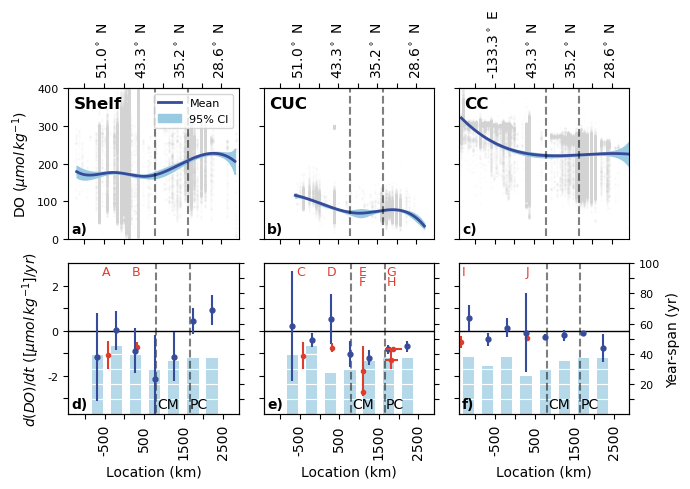

In [19]:
variable = 'DO (umol kg-1)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,100,200,300,400])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,100,200,300,400],fontsize=8)
ax[0,0].set_ylabel('DO ($\mu mol \,kg^{-1}$)',fontsize=10)
ax[0,0].legend(fontsize=8)



# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-3,-2,-1,0,1,2])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(DO)/dt \,\,([\mu mol \,kg^{-1}]/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['','-2','','0','','2'],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# add observational data
ax[1,0].errorbar(Oxlit.dist[Oxlit.current=='shelf'], Oxlit.rate[Oxlit.current=='shelf'],yerr=Oxlit.sdev[Oxlit.current=='shelf'], c='#DD3D2D',fmt='.')
ax[1,1].errorbar(Oxlit.dist[Oxlit.current=='CUC'], Oxlit.rate[Oxlit.current=='CUC'],yerr=Oxlit.sdev[Oxlit.current=='CUC'], xerr=Oxlit.distDiff[Oxlit.current=='CUC'], c='#DD3D2D',fmt='.',zorder=6)
ax[1,2].errorbar(Oxlit.dist[Oxlit.current=='CC'], Oxlit.rate[Oxlit.current=='CC'],yerr=Oxlit.sdev[Oxlit.current=='CC'], c='#DD3D2D',fmt='.')

ax[1,0].text(0.22,0.99,'A',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9)
ax[1,0].text(0.4,0.99,'B',ha='center',va='top',color='#DD3D2D',transform=ax[1,0].transAxes,fontsize=9)

ax[1,1].text(0.22,0.99,'C',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.40,0.99,'D',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.58,0.99,'E',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.58,0.92,'F',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.75,0.99,'G',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)
ax[1,1].text(0.75,0.92,'H',ha='center',va='top',color='#DD3D2D',transform=ax[1,1].transAxes,fontsize=9)

ax[1,2].text(0.03,0.99,'I',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9)
ax[1,2].text(0.4,0.99,'J',ha='center',va='top',color='#DD3D2D',transform=ax[1,2].transAxes,fontsize=9)

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/OxyTrends.png')

# NO3

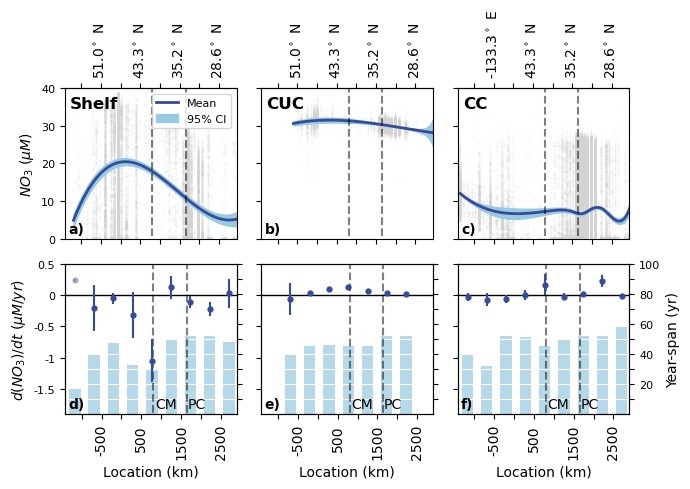

In [20]:
variable = 'NO3 (uM)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,10,20,30,40])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,10,20,30,40],fontsize=8)
ax[0,0].set_ylabel('$NO_3$ ($\mu M$)',fontsize=10)
ax[0,0].legend(fontsize=8)



# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-1.5,-1,-0.5,0,0.5])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d(NO_3)/dt \,\,(\mu M/yr)$',fontsize=10)
ax[1,0].set_yticklabels([-1.5,-1,-0.5,0,0.5],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/NitTrends.png')

# [TA-DIC]

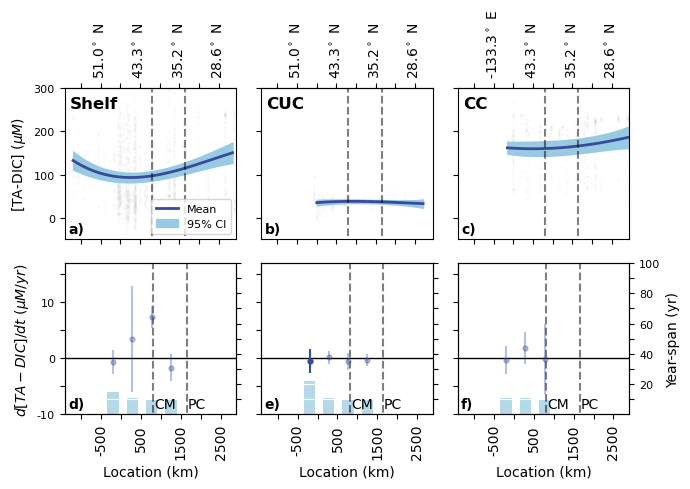

In [21]:
variable = '[TA-DIC] (uM)'

fig, ax = plt.subplots(2,3, figsize=(7,5))

# trend in space plot in top row
plot_property_NStrend(obs_shelf['dist'], variable, 'shelf', (0,0))
plot_property_NStrend(obs_cuc['dist'], variable, 'CUC', (0,1))
plot_property_NStrend(obs_cc['dist'], variable, 'CC', (0,2))
for i in range(3):
    ax[0,i].set_yticks([0,100,200,300])
    ax[0,i].set_yticklabels([])
ax[0,0].set_yticklabels([0,100,200,300],fontsize=8)
ax[0,0].set_ylabel('[TA-DIC] ($\mu M$)',fontsize=10)
ax[0,0].legend(fontsize=8)


# trend in time plots in bottom row
plot_ratediff_NS_CI(variable, 'shelf', (1,0))
plot_ratediff_NS_CI(variable, 'CUC', (1,1))
plot_ratediff_NS_CI(variable, 'CC', (1,2),yrlabel=True)
for i in range(3):
    ax[1,i].set_yticks([-10,-5,0,5,10,15])
    ax[1,i].set_xlabel('Location (km)')
ax[1,0].set_ylabel('$d[TA-DIC]/dt \,\,(\mu M/yr)$',fontsize=10)
ax[1,0].set_yticklabels(['-10','','0','','10',''],fontsize=8)
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])

# titles
ax[0,0].text(0.03,0.95,'Shelf',ha='left',va='top',color='k',weight='bold',transform=ax[0,0].transAxes,fontsize=12,zorder=6)
ax[0,1].text(0.03,0.95,'CUC',ha='left',va='top',color='k',weight='bold',transform=ax[0,1].transAxes,fontsize=12,zorder=6)
ax[0,2].text(0.03,0.95,'CC',ha='left',va='top',color='k',weight='bold',transform=ax[0,2].transAxes,fontsize=12,zorder=6)
# plot labels
ax[0,0].text(0.02,0.02,'a)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,0].transAxes,fontsize=10,zorder=6)
ax[0,1].text(0.02,0.02,'b)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,1].transAxes,fontsize=10,zorder=6)
ax[0,2].text(0.02,0.02,'c)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[0,2].transAxes,fontsize=10,zorder=6)
ax[1,0].text(0.02,0.02,'d)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,0].transAxes,fontsize=10,zorder=6)
ax[1,1].text(0.02,0.02,'e)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,1].transAxes,fontsize=10,zorder=6)
ax[1,2].text(0.02,0.02,'f)',ha='left',va='bottom',color='k',weight='semibold',transform=ax[1,2].transAxes,fontsize=10,zorder=6)

plt.tight_layout()

plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/CarbTrends.png')